In [1]:
# 載入數據集
from datasets import load_dataset
from haystack import Document

# 加載 PubMedQA 數據集，取前 1000 條數據
dataset = load_dataset(
    "vblagoje/PubMedQA_instruction",
    split="train"
)
dataset = dataset.select(range(1000))

# 提取文件
all_documents = [
    Document(content=doc["context"])
    for doc in dataset
]
# 提取問題
all_questions = [
    doc["instruction"]
    for doc in dataset
]
# 提取真實答案
all_ground_truth_answers = [
    doc["response"]
    for doc in dataset
]

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import List
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

In [3]:
# 建立索引管道
indexing = Pipeline()

In [4]:
# 建立 `文件嵌入器`
document_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/all-MiniLM-L6-v2"
)

# 建立 `內存文件儲存` 對象
document_store = InMemoryDocumentStore()

# 使用儲存對象建立 `文件寫入器`
document_writer = DocumentWriter(
    document_store=document_store,
    # 重複時跳過
    policy=DuplicatePolicy.SKIP
)

In [5]:
# 添加管道元件
indexing.add_component(
    instance=document_embedder,
    name="document_embedder"
)
indexing.add_component(
    instance=document_writer,
    name="document_writer"
)

In [6]:
# 連接管道元件：連接嵌入器和寫入器
indexing.connect(
    "document_embedder.documents",
    "document_writer.documents"
)

🚅 Components
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - document_embedder.documents -> document_writer.documents (List[Document])

In [7]:
# 執行索引管道
indexing.run(
    {"document_embedder": {"documents": all_documents}}
)

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/sentence_transformers/SentenceTransformer.py:174: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(
/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


{'document_writer': {'documents_written': 1000}}

In [8]:
indexing.draw('ex15-1.png')

In [9]:
import os
from getpass import getpass
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
# 設置 OpenAI API 金鑰
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

In [10]:
from haystack.components.builders import AnswerBuilder, PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

In [11]:
# 定義生成答案的模板
template = """
        您必須僅根據給定的上下文資訊回答以下問題。

        上下文:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        問題: {{question}}
        答案:
        """

In [12]:
# 建立 RAG 管道
rag_pipeline = Pipeline()

In [13]:
rag_pipeline.add_component(
    "query_embedder", 
    SentenceTransformersTextEmbedder(
        model="sentence-transformers/all-MiniLM-L6-v2"
    )
)
rag_pipeline.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(document_store, top_k=3)
)
rag_pipeline.add_component(
    "prompt_builder",
    PromptBuilder(template=template)
)
rag_pipeline.add_component(
    "generator",
    OpenAIGenerator(model="gpt-4-turbo")
)
rag_pipeline.add_component(
    "answer_builder",
    AnswerBuilder()
)

In [14]:
# 連接管道的組件
rag_pipeline.connect(
    "query_embedder", "retriever.query_embedding"
)
rag_pipeline.connect(
    "retriever", "prompt_builder.documents"
)
rag_pipeline.connect(
    "prompt_builder", "generator"
)
rag_pipeline.connect(
    "generator.replies", "answer_builder.replies"
)
rag_pipeline.connect(
    "generator.meta", "answer_builder.meta"
)
rag_pipeline.connect(
    "retriever", "answer_builder.documents"
)

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> answer_builder.replies (List[str])
  - generator.meta -> answer_builder.meta (List[Dict[str, Any]])

In [17]:
# 問題：小兒肝移植術後早期降鈣素原高是否表示術後效果不佳？
question = "Do high levels of procalcitonin in the early phase after?"

# 運行管道
response = rag_pipeline.run(
    {
        "query_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question}
    }
)
# 輸出
print(response["answer_builder"]["answers"][0].data)

Batches: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


pediatric liver transplantation correlate with higher morbidity and complications? Yes, high levels of procalcitonin (PCT) on postoperative day 2 are associated with higher International Normalized Ratio values on postoperative day 5, more frequent cases of primary graft non-function, longer stays in the pediatric intensive care unit, and longer durations on mechanical ventilation. This suggests that elevated PCT levels can indeed be an indicator of higher morbidity and complications in the early phase after pediatric liver transplantation.


In [27]:
# 建立 RAG 管道
new_rag_pipeline = Pipeline()

In [28]:
# 改用支持多語言的嵌入模型
new_rag_pipeline.add_component(
    # 這是新的嵌入模型名稱
    "multi_language_embedder",
    SentenceTransformersTextEmbedder(
        # 使用新的嵌入模型
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
    )
)
# 其餘組件設定維持不便
new_rag_pipeline.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(document_store, top_k=3)
)
new_rag_pipeline.add_component(
    "prompt_builder",
    PromptBuilder(template=template)
)
new_rag_pipeline.add_component(
    "generator",
    OpenAIGenerator(model="gpt-4-turbo")
)
new_rag_pipeline.add_component(
    "answer_builder",
    AnswerBuilder()
)

In [29]:
# 連接管道的組件
new_rag_pipeline.connect(
    "multi_language_embedder", "retriever.query_embedding"
)
new_rag_pipeline.connect(
    "retriever", "prompt_builder.documents"
)
new_rag_pipeline.connect(
    "prompt_builder", "generator"
)
new_rag_pipeline.connect(
    "generator.replies", "answer_builder.replies"
)
new_rag_pipeline.connect(
    "generator.meta", "answer_builder.meta"
)
new_rag_pipeline.connect(
    "retriever", "answer_builder.documents"
)

🚅 Components
  - multi_language_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - multi_language_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> answer_builder.replies (List[str])
  - generator.meta -> answer_builder.meta (List[Dict[str, Any]])

In [35]:
new_rag_pipeline.draw('new_rag_pipeline.png')

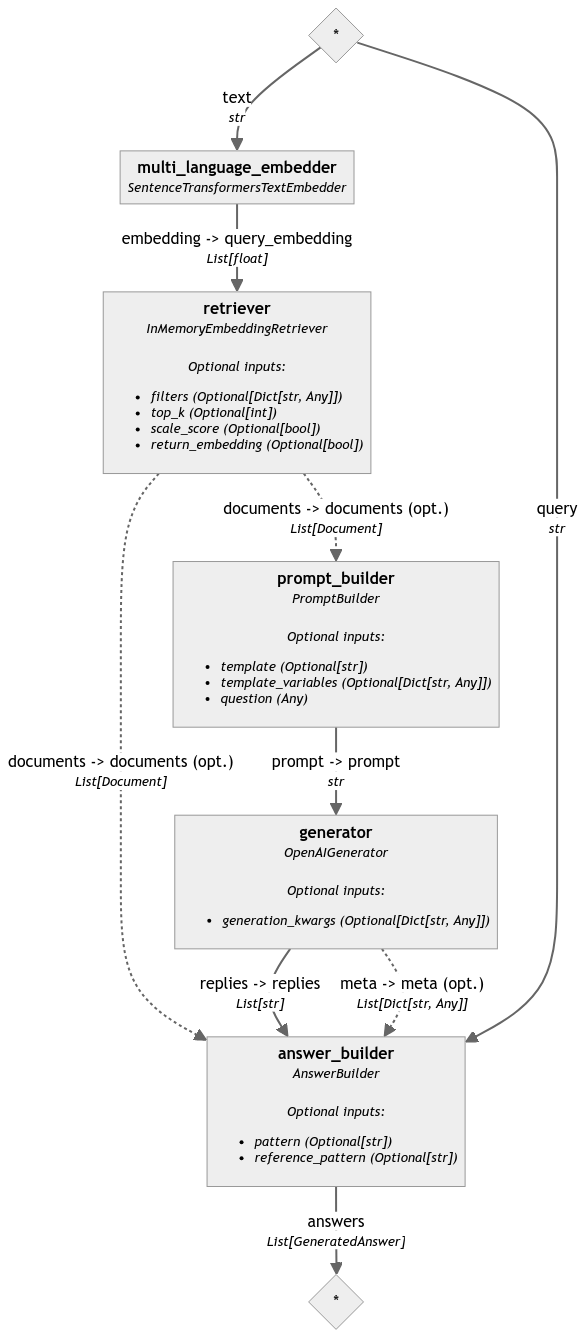

In [64]:
from utils.draw_pipeline import draw_and_display

draw_and_display(new_rag_pipeline, 'new_rag_pipeline.png')

In [33]:
# 問題
question = "小兒肝移植術後早期降鈣素原高是否表示術後效果不佳？"

# 運行管道
response = new_rag_pipeline.run(
    {
        # 使用新的嵌入模型 `multi_language_embedder`
        "multi_language_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question}
    }
)
# 輸出
print(response["answer_builder"]["answers"][0].data)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


是的，小兒肝移植術後早期降鈣素原(PCT)水平的升高與術後效果不佳有關。在上述的研究中，顯示術後第二天PCT水平高的患者在術後第五天有更高的國際標準化比率值，更常出現原發性移植物無功能的情況，並且在兒科重症監護病房停留時間更長，以及需要更長時間的機械通氣。这些結果說明PCT水平的升高與術後效果不佳有關，尤其是在肝功能及病人恢復方面。


In [65]:
import random

# 隨機抽取 25 個問題和標籤
# 問題、具體答案、具體文件
questions, ground_truth_answers, ground_truth_docs = zip(
    *random.sample(
        list(zip(
            all_questions,
            all_ground_truth_answers,
            all_documents
        )),
        25
    )
)

In [69]:
# 返回的答案
rag_answers = []
# 索引到的文件
retrieved_docs = []
# 遍歷問題
for question in list(questions):
    # 運行管道
    response = new_rag_pipeline.run({
        "multi_language_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question}
    })
    # 輸出
    print(f"Question: {question}")
    print("Answer from pipeline:")
    print(response["answer_builder"]["answers"][0].data)
    print("\n-----------------------------------\n")

    # 記錄答案
    rag_answers.append(
        response["answer_builder"]["answers"][0].data
    )
    # 紀錄檢索到的文件
    retrieved_docs.append(
        response["answer_builder"]["answers"][0].documents
    )

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Question: Do [ EuroSCORE underestimate the mortality risk in cardiac valve surgery of Mexican population ]?
Answer from pipeline:
Yes, the EuroSCORE does underestimate the mortality risk in cardiac valve surgery of the Mexican population. The data from the study conducted at the Instituto Nacional de Cardiología Ignacio Chávez (INCICh) in México showed that the actual total mortality rate was 9.68%, which was significantly higher than the mortality predicted by the additive (5%) and logistic (5.6%) EuroSCORE models. In addition, the Hosmer-Lemeshow test results had a P<.001 for both models, suggesting that the models did not fit the data well, indicating poor calibration in predicting mortality in this particular population.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Question: Is percutaneous intervention of circumflex chronic total occlusions associated with worse procedural outcomes : insights from a Multicentre US Registry?
Answer from pipeline:
The provided text context does not contain information specifically about the percutaneous intervention of circumflex chronic total occlusions or related procedural outcomes from a Multicentre US Registry. Therefore, based on the text provided, I am unable to answer the question about the association of percutaneous intervention of circumflex chronic total occlusions with procedural outcomes.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


Question: Does pentoxifylline associated to hypertonic saline solution attenuate inflammatory process and apoptosis after intestinal ischemia/reperfusion in rats?
Answer from pipeline:
The given context does not provide any information regarding the use of pentoxifylline in combination with hypertonic saline solution for attenuating the inflammatory process and apoptosis after intestinal ischemia/reperfusion in rats. Therefore, based on the provided text, I cannot confirm or deny the efficacy of pentoxifylline with hypertonic saline solution for this purpose.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


Question: Is glycemic variability evaluated by continuous glucose monitoring system associated with the 10-y cardiovascular risk of diabetic patients with well-controlled HbA1c?
Answer from pipeline:
Yes, glycemic variability evaluated by continuous glucose monitoring system is associated with the 10-year cardiovascular risk in diabetic patients with well-controlled HbA1c. The study found that the levels of standard deviation of blood glucose (SDBG) and mean amplitudes of glycemic excursion (MAGE), which are measures of glycemic variability derived from 72-hour continuous glucose monitoring, significantly increased along with the elevation of the 10-year cardiovascular disease risk in type 2 diabetes mellitus patients who maintained an HbA1c of ≤7.0%. Moreover, Framingham risk score (FRS) was positively correlated with SDBG and MAGE, suggesting that higher glycemic variability is linked to an increased risk of cardiovascular events in these patients.

----------------------------------

Batches: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


Question: Do a simplified method of preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery?
Answer from pipeline:
The given context does not provide information directly related to methods for preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery. The passages provided focus on treatment outcomes in other medical interventions such as extracorporeal shockwave therapy for shoulder adhesive capsulitis, capsular closure after hip arthroscopy, and sensory recovery after Le Fort I osteotomies. Therefore, based on the supplied text, no specific method to prevent accidental swallowing or aspiration of an implant hex drive during implant recovery can be derived.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


Question: Is altered perineal microbiome associated with vulvovaginitis and urinary tract infection in preadolescent girls?
Answer from pipeline:
Yes, the altered periurethral microbiome is associated with vulvovaginitis and urinary tract infections (UTIs) in preadolescent girls. The research indicates that periurethral swabs from children with vulvovaginitis showed a statistically significant increase in uropathogenic bacteria, predominantly Enterococcus species and Escherichia coli, compared to swabs from girls without vulvovaginitis. Additionally, a higher proportion of urine cultures from girls with vulvovaginitis were positive for UTIs, and the dominant organisms in the urine cultures matched the species and antibiotic sensitivity profile of the corresponding periurethral swab. This supports the hypothesis that vulvovaginitis contributes to UTIs in this population by increasing periurethral colonization with uropathogens.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Question: Does inhibition of urothelial P2X3 receptors prevent desensitization of purinergic detrusor contractions in the rat bladder?
Answer from pipeline:
Yes, the inhibition of urothelial P2X3 receptors prevents desensitization of purinergic detrusor contractions in the rat bladder, but only in bladder strips with an intact urothelium. This effect was observed during experiments involving electrical field stimulation (EFS) in the study, indicating that P2X3 receptors play a significant role in modulating bladder contractions through their presence in the urothelium.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


Question: Is fasting serum dipeptidyl peptidase-4 activity independently associated with alanine aminotransferase in type 1 diabetic patients?
Answer from pipeline:
Yes, fasting serum dipeptidyl peptidase-4 (DPP4) activity is independently associated with alanine aminotransferase (ALT) in type 1 diabetic patients. The study found that DPP4 activity showed a positive correlation with ALT (r=0.364, p=0.015), and this association remained significant after controlling for factors such as age, gender, diabetes duration, the use of statins, and antihypertensives (p=0.025).

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


Question: Does atrial natriuretic peptide induce peroxisome proliferator activated receptor γ during cardiac ischemia-reperfusion in swine heart?
Answer from pipeline:
Yes, atrial natriuretic peptide induces peroxisome proliferator activated receptor γ during cardiac ischemia-reperfusion in swine heart. This is supported by the study where the mRNA and protein expressions of peroxisome proliferator activated receptor γ were significantly higher in the ischemic area of the swine hearts treated with carperitide (synthetic human atrial natriuretic peptide) compared to the control group.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


Question: Does a systematic review identify valid comorbidity indices derived from administrative health data?
Answer from pipeline:
No, the systematic reviews described in the context do not focus on identifying valid comorbidity indices derived from administrative health data. Instead, they concentrate on assessing the quality of clinical practice guidelines, estimating disease incidence in primary care, and investigating methods to adjust for dissemination bias in meta-analyses.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Question: Do azo pigments and quinacridones induce delayed hypersensitivity in red tattoos?
Answer from pipeline:
Yes, both azo pigments and quinacridones have been known to induce delayed hypersensitivity reactions in red tattoos. In the described study, five of the reactions occurred with azo pigments, and two reactions occurred with quinacridones (Violet 19 and Red 122).

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


Question: Does recipient T cell TIM-3 and hepatocyte galectin-9 signalling protect mouse liver transplants against ischemia-reperfusion injury?
Answer from pipeline:
Yes, recipient T cell TIM-3 and hepatocyte galectin-9 signaling protect mouse liver transplants against ischemia-reperfusion injury. In the conducted studies, the expression of TIM-3 in circulating CD4+ T cells in recipients led to decreased expression of T-bet/IFN-γ and increased expression of GATA3 and IL-4/IL-10, which are associated with a protective response in liver transplants. Additionally, TIM-3 promoted a T cell exhaustion phenotype, which further helped in suppressing T cell activation that otherwise contributes to inflammation and tissue injury in ischemia-reperfusion scenarios. Furthermore, TIM-3 induction decreased infiltration and function of neutrophils and macrophages in liver transplants, contributing to reduced inflammation.

Concurrently, the studies documented the role of galectin-9, a natural TIM-3 li

Batches: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Question: Is hidradenitis suppurativa a systemic disease with substantial comorbidity burden : a chart-verified case-control analysis?
Answer from pipeline:
Yes, hidradenitis suppurativa (HS) is considered a systemic disease with a substantial comorbidity burden. The excerpt provided from the research conducted on a large patient care database at Massachusetts General Hospital demonstrates that HS is associated with multiple significant comorbidities including smoking, arthropathies, dyslipidemia, polycystic ovarian syndrome, psychiatric disorders, obesity, drug dependence, hypertension, diabetes, thyroid disease, alcohol dependence, and lymphoma. All of these comorbidities were diagnosed more frequently in patients with HS compared to controls, reflecting the systemic nature and significant health burden associated with hidradenitis suppurativa.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Question: Is premature ejaculation associated with glycemic control in Type 1 diabetes?
Answer from pipeline:
Yes, premature ejaculation is associated with glycemic control in Type 1 diabetes. The study found significant associations between hemoglobin A1c levels and both the premature ejaculation diagnostic tool (PEDT) score (r = 0.27; P = 0.006) and the self-estimated intravaginal ejaculatory latency time (IELT) (r = -0.3; P = 0.01). This indicates that poorer glycemic control is related to higher rates of premature ejaculation among Type 1 diabetic patients. Additionally, the study demonstrated an association between the low blood glucose index (LBGI) and the PEDT score (r = 0.43; P = 0.01), further linking glycemic variability to premature ejaculation in this population.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


Question: Is chronic thromboembolic pulmonary hypertension associated with iron overload?
Answer from pipeline:
No, chronic thromboembolic pulmonary hypertension (CTEPH) is not associated with iron overload. The case-control study described in the context did not find a significant difference in the levels of free iron, hepcidin-25, soluble transferrin receptor (sTfR), ferritin, and the sTfR/ferritin ratio between CTEPH patients and the controls. These findings suggest that iron metabolism parameters, including iron overload, do not differentiate CTEPH patients from chronic PE patients without pulmonary hypertension.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


Question: Is topical clobetasol in conjunction with topical tretinoin effective in preventing scar formation after superficial partial-thickness burn ulcers of the skin : A retrospective study?
Answer from pipeline:
Yes, the combination of topical clobetasol and tretinoin was found effective in preventing scar formation after superficial partial-thickness burns. According to the retrospective study mentioned in the context, patients who received topical clobetasol propionate 0.05% ointment with tretinoin 0.05% cream after re-epithelialization of burns demonstrated a significantly lower rate of scar formation compared to those who did not receive any medication. Specifically, among patients with deep erythema after re-epithelialization, only 19% of those treated with clobetasol and tretinoin developed scars, whereas 64% of those who did not receive the combination therapy developed scars (p = 0.01). This suggests that the combination therapy effectively reduces the likelihood of scar fo

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Question: Are povidone-iodine rectal cleansing and targeted antimicrobial prophylaxis using rectal swab cultures in men undergoing transrectal ultrasound-guided prostate biopsy associated with reduced incidence of postoperative infectious complications?
Answer from pipeline:
Yes, povidone-iodine rectal cleansing combined with targeted antimicrobial prophylaxis based on rectal swab culture results in men undergoing transrectal ultrasound-guided prostate biopsy is associated with a reduced incidence of postoperative infectious complications. This was demonstrated by the lower rate of infectious complications in group C (1.3%) who received both povidone-iodine rectal cleansing and targeted antimicrobial prophylaxis, compared to groups A (3.6%) and B (2.9%) which received either no rectal cleansing or only empirical antimicrobial prophylaxis respectively. Additionally, the incidences of acute prostatitis and bacteremia were significantly lower in group C than in the other groups, further s

Batches: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


Question: Are viruses frequently present as the infecting agent in acute exacerbations of chronic obstructive pulmonary disease in patients presenting to hospital?
Answer from pipeline:
Yes, viruses are frequently present as the infecting agent in acute exacerbations of chronic obstructive pulmonary disease (AECOPD) in patients presenting to hospital. The data reveals that most patients with AECOPD who had nasopharyngeal aspirate (NPA) sent for viral PCR testing demonstrated a high positivity rate, with 59 out of 102 patients (58%) testing positive for at least one virus. The most common viruses identified among these patients were Influenza A, Rhinovirus, and respiratory syncytial virus A/B. These findings suggest that viral infections are a significant contributing factor to hospitalizations due to AECOPD exacerbations.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Question: Does the Boston keratoprosthesis provide a wide depth of focus?
Answer from pipeline:
Yes, the Boston keratoprosthesis (KPro) tends to provide a wider depth of focus, as indicated by a less steep through-focus curve compared to control eyes with fixed pupil sizes.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


Question: Does plasmid pPCP1-derived sRNA HmsA promote biofilm formation of Yersinia pestis?
Answer from pipeline:
Yes, the plasmid pPCP1-derived sRNA HmsA promotes biofilm formation of Yersinia pestis. HmsA contributes to enhanced biofilm formation by positively regulating genes associated with biofilm synthesis, such as hmsHFRS, hmsT, and hmsCDE. Additionally, the deletion of the hmsA gene leads to a significant reduction in the concentration of c-di-GMP, a key molecule associated with biofilm formation, further supporting its role in promoting biofilm development in Y. pestis.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 22.21it/s]


Question: Is circulating retinol binding protein 4 associated with coronary lesion severity of patients with coronary artery disease?
Answer from pipeline:
The information provided does not include any data or analysis regarding circulating retinol binding protein 4 and its association with the severity of coronary lesions in patients with coronary artery disease. Therefore, the question cannot be answered based on the given context.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]


Question: Does dietary guanidinoacetic acid increase brain creatine levels in healthy men?
Answer from pipeline:
Yes, dietary guanidinoacetic acid does increase brain creatine levels in healthy men. In the study mentioned, after 8 weeks of oral GAA administration, brain creatine levels increased substantially in the white matter, gray matter, and cerebellum, with an initial increase of 10.7% reported after 4 weeks, and an additional upsurge (7.7%) from the weeks 4 to 8 follow-up.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Question: Is malonate as a ROS product associated with pyruvate carboxylase activity in acute myeloid leukaemia cells?
Answer from pipeline:
The provided text does not contain any mention of malonate, reactive oxygen species (ROS), pyruvate carboxylase, or acute myeloid leukemia cells. Therefore, the information to answer whether malonate, as a ROS product, is associated with pyruvate carboxylase activity in acute myeloid leukemia cells is not available in the provided context.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Question: Does differential functional readthrough over homozygous nonsense mutations contribute to the bleeding phenotype in coagulation factor VII deficiency?
Answer from pipeline:
Yes, differential functional readthrough over homozygous nonsense mutations does contribute to the bleeding phenotype in coagulation factor VII deficiency. The context indicates that the readthrough of specific stop codons, such as p.Ser112X (associated with life-threatening symptoms) and p.Cys132X (associated with moderate symptoms), allows the insertion of either wild-type or tolerated residues that can produce functional proteins. This mechanism impacts the severity of the bleeding symptoms observed in individuals with these mutations.

-----------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


Question: Is blood transfusion associated with recurrence of hepatocellular carcinoma after hepatectomy in Child-Pugh class A patients?
Answer from pipeline:
Yes, blood transfusion is associated with the recurrence of hepatocellular carcinoma after hepatectomy in Child-Pugh class A patients. This is supported by the data showing significantly lower recurrence-free survival (RFS) rates among transfused patients compared to nontransfused patients, even after adjusting for other factors through inverse probability of treatment weighting (IPTW) analysis.

-----------------------------------



In [70]:
from haystack.components.evaluators.document_mrr import DocumentMRREvaluator
from haystack.components.evaluators.faithfulness import FaithfulnessEvaluator
from haystack.components.evaluators.sas_evaluator import SASEvaluator

評估管道

In [71]:
# 建立評估管道
eval_pipeline = Pipeline()

In [72]:
eval_pipeline.add_component(
    "doc_mrr_evaluator",
    DocumentMRREvaluator()
)
eval_pipeline.add_component(
    "faithfulness",
    FaithfulnessEvaluator()
)
eval_pipeline.add_component(
    "sas_evaluator",
    SASEvaluator(model="sentence-transformers/all-MiniLM-L6-v2")
)

In [73]:
# 運行評估管道
results = eval_pipeline.run({
    "doc_mrr_evaluator": {
        "ground_truth_documents": list([d] for d in ground_truth_docs),
        "retrieved_documents": retrieved_docs
    },
    "faithfulness": {
        "questions": list(questions),
        "contexts": list([d.content] for d in ground_truth_docs),
        "predicted_answers": rag_answers
    },
    "sas_evaluator": {
        "predicted_answers": rag_answers,
        "ground_truth_answers": list(ground_truth_answers)
    }
})

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/transformers/models/auto/configuration_auto.py:1123: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/sentence_transformers/SentenceTransformer.py:174: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(
100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


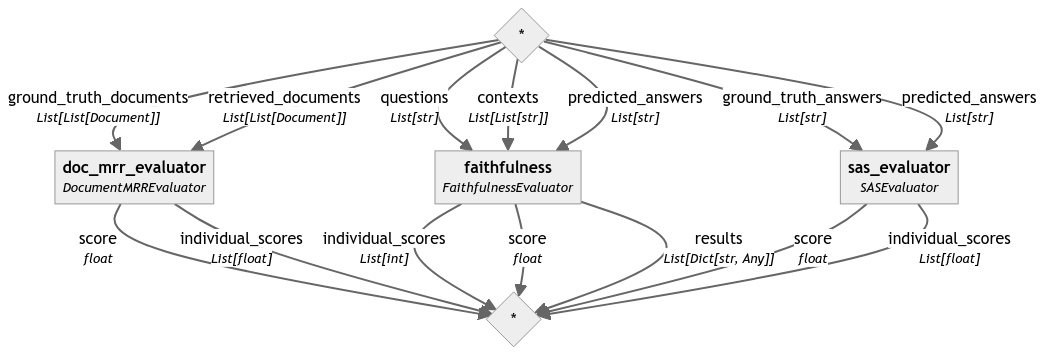

In [74]:
draw_and_display(eval_pipeline, "eval_pipeline.png")

In [75]:
from haystack.evaluation.eval_run_result import EvaluationRunResult

inputs = {
    "question": list(questions),
    "contexts": list([d.content] for d in ground_truth_docs),
    "answer": list(ground_truth_answers),
    "predicted_answer": rag_answers,
}

evaluation_result = EvaluationRunResult(
    run_name="pubmed_rag_pipeline",
    inputs=inputs,
    results=results
)
evaluation_result.score_report()

,metrics,score
0,doc_mrr_evaluator,0.713333
1,faithfulness,0.880000
2,sas_evaluator,0.658183


In [77]:
import pandas as pd

# 將評估結果轉換為 DataFrame
results_df = evaluation_result.to_pandas()
print(results_df)

# 保存 DataFrame 為 CSV 文件
results_df.to_csv("evaluation_results.csv", index=False)

                                             question  \
0   Do [ EuroSCORE underestimate the mortality ris...   
1   Is percutaneous intervention of circumflex chr...   
2   Does pentoxifylline associated to hypertonic s...   
3   Is glycemic variability evaluated by continuou...   
4   Do a simplified method of preventing implant h...   
5   Is altered perineal microbiome associated with...   
6   Does inhibition of urothelial P2X3 receptors p...   
7   Is fasting serum dipeptidyl peptidase-4 activi...   
8   Does atrial natriuretic peptide induce peroxis...   
9   Does a systematic review identify valid comorb...   
10  Do azo pigments and quinacridones induce delay...   
11  Does recipient T cell TIM-3 and hepatocyte gal...   
12  Is hidradenitis suppurativa a systemic disease...   
13  Is premature ejaculation associated with glyce...   
14  Is chronic thromboembolic pulmonary hypertensi...   
15  Is topical clobetasol in conjunction with topi...   
16  Are povidone-iodine rectal 

In [79]:
# 使用 Pandas 過濾結果，顯示語義答案相似性最高的 3 個和最低的 3 個
top_3 = results_df.nlargest(3, 'sas_evaluator')
bottom_3 = results_df.nsmallest(3, 'sas_evaluator')
combined_results = pd.concat([top_3, bottom_3])

# 保存過濾後的結果為另一個 CSV 文件
combined_results.to_csv("top_and_bottom_results.csv", index=False)

# 顯示過濾後的結果
combined_results

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
8,Does atrial natriuretic peptide induce peroxis...,[Atrial natriuretic peptide is a cardiac atriu...,Atrial natriuretic peptide may achieve its car...,"Yes, atrial natriuretic peptide induces peroxi...",1.0,1.0,0.851610
2,Does pentoxifylline associated to hypertonic s...,[To evaluate intestinal inflammatory and apopt...,The combined use of pentoxifylline and hyperto...,The given context does not provide any informa...,0.0,1.0,0.837528
15,Is topical clobetasol in conjunction with topi...,[Deep erythema and inflammation after re-epith...,Clobetasol + tretinoin can significantly decre...,"Yes, the combination of topical clobetasol and...",1.0,1.0,0.824670
12,Is hidradenitis suppurativa a systemic disease...,[Hidradenitis suppurativa (HS) is a chronic in...,Control subjects were not validated for absenc...,"Yes, hidradenitis suppurativa (HS) is consider...",1.0,1.0,0.267943
1,Is percutaneous intervention of circumflex chr...,[We sought to determine whether outcomes of ch...,"In a contemporary, multicentre CTO PCI registr...",The provided text context does not contain inf...,0.0,1.0,0.295731
22,Is malonate as a ROS product associated with p...,[The role of anaplerotic nutrient entry into t...,This study extends the interest in the PC acti...,The provided text does not contain any mention...,0.0,0.0,0.436141
